# **Titanic - Machine Learning from Disaster - Baseline**

このノートブックでは、  
Kaggleコンペティション「Titanic - Machine Learning from Disaster」のデータセットを使用し、  
生存者を予測する機械学習モデルのベースラインを構築しております。  
本ベースラインでは、  
LightGBMを用いた単純なモデルからスタートし、  
今後の改善や特徴量エンジニアリングの土台としております。

## モジュールの読み込み

In [1]:
import os
from pathlib import Path
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import lightgbm as lgb
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

## データの読み込み(kaggle.jsonで読み込む)

In [2]:
# kaggle.jsonのアップロード
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akimasa6637","key":"8510f9e17e9efcce531d3750fbc4a0ee"}'}

In [3]:
# kaggle.json用のフォルダ作成
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# アクセス権限の許可
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Pathの設定
path = Path(".")
data_path = path / "data"
input_path = data_path / "input"
output_path = data_path / "output"

# フォルダの作成
input_path.mkdir(parents=True, exist_ok=True)
output_path.mkdir(parents=True, exist_ok=True)

In [5]:
# データセットのダウンロード
!kaggle competitions download -c titanic -p {input_path}
# titanic.zipの解凍
!unzip {input_path}/titanic.zip -d {input_path}
# titanic.zipの削除
!rm {input_path}/titanic.zip

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 150MB/s]
Archive:  data/input/titanic.zip
  inflating: data/input/gender_submission.csv  
  inflating: data/input/test.csv     
  inflating: data/input/train.csv    


In [6]:
# csvpathの取得
csv_list = sorted(glob(f"{input_path}/*.csv"))

# csvの読み込み
train = pd.read_csv(csv_list[2])
test = pd.read_csv(csv_list[1])
submission = pd.read_csv(csv_list[0])

# 配列の要素数の確認
print(train.shape, test.shape, submission.shape)

(891, 12) (418, 11) (418, 2)


## データの確認

In [7]:
# datasetの作成(欠損値の補完のため)
dataset = pd.concat([train, test], sort=False)
df = dataset.copy()

# dfの確認
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
# 各カラムのdtypeの確認
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [9]:
# 詳細なデータの確認(numberカラム)
df.describe(include=np.number)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [10]:
# 詳細なデータの確認(objectカラム)
df.describe(exclude=np.number)

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Kelly, Mr. James",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


## データの前処理

In [11]:
# 欠損値の確認
df.isnull().sum()

,0
PassengerId,0
Survived,418
Pclass,0
Name,0
Sex,0
Age,263
SibSp,0
Parch,0
Ticket,0
Fare,1


In [12]:
# Cabinの削除(欠損値が多いため)
df.drop(columns="Cabin", inplace=True)

# 欠損値の処理
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Fare"] = df["Fare"].fillna(df["Fare"].median())
df["Embarked"] = df["Embarked"].fillna("S")

In [13]:
# 再度、欠損値の確認
df.isnull().sum()

,0
PassengerId,0
Survived,418
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [14]:
# カテゴリ変換
cat_cols = ["Survived", "Sex", "Embarked"]
df[cat_cols] = df[cat_cols].astype("category")

In [15]:
# 特徴量の選択
FEATURES = ["Age", "Fare", "Pclass", "Sex", "Embarked", "SibSp", "Parch"]

In [16]:
# dfを train と test に再分割(Survivedがnanではない=>train, Survivedがnanである=>test)
train = df[df["Survived"].notnull()]
test = df[df["Survived"].isnull()]

# 配列の要素数の確認
print(train.shape, test.shape)

(891, 11) (418, 11)


## 学習ループ

In [17]:
# ハイパーパラメータの設定
FOLDS = 5
seed = 42

# 交差検証の設定
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

In [18]:
# 変数の作成
auc_scores_train = []
auc_scores_valid = []
acc_score = []
imp = pd.DataFrame()
models = []

# 交差検証での学習
for fold, (train_idx, valid_idx) in enumerate(cv.split(train[FEATURES], train["Survived"])):
    print("#"*40)
    print(f"### [FOLD {fold+1}/{FOLDS}]")
    print(f"### train idx: {len(train_idx)}, valid idx{len(valid_idx)}")
    print("#"*40)

    # 各データの分割
    X_train = train.loc[train_idx, FEATURES]
    y_train = train.loc[train_idx, "Survived"]
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, "Survived"]

    # モデルの設定
    model = LGBMClassifier(
        n_estimators=5000,
        learning_rate=0.03,
        num_leaves=31,
        metrics="auc",
        random_state=seed,
        verbose=-1
        )

    # 学習ループ
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(10)
        ]
    )

    # ROC AUC Score
    ## 説明変数から目的変数の予測
    pred_train = model.predict_proba(X_train)[:, 1]
    pred_valid = model.predict_proba(X_valid)[:, 1]
    ## 評価
    auc_train = roc_auc_score(y_train, pred_train)
    auc_valid = roc_auc_score(y_valid, pred_valid)

    # Accuracy Score
    ## 説明変数から目的変数の予測
    pred_valid = model.predict(X_valid)
    ## 評価
    acc = accuracy_score(y_valid, pred_valid)

    # 評価結果とモデルの追加
    auc_scores_train.append(auc_train)
    auc_scores_valid.append(auc_valid)
    acc_score.append(acc)
    models.append(model)

    # 重要度のDF作成
    _imp = pd.DataFrame({
        "features": FEATURES,
        "importance": model.feature_importances_,
        "fold": fold+1
    })
    # 重要度の追加
    imp = pd.concat([imp, _imp], axis=0)

    print()

########################################
### [FOLD 1/5]
### train idx: 712, valid idx179
########################################
Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.902467	valid_1's auc: 0.892227
[20]	training's auc: 0.910603	valid_1's auc: 0.904545
[30]	training's auc: 0.914278	valid_1's auc: 0.905336
[40]	training's auc: 0.920469	valid_1's auc: 0.909025
[50]	training's auc: 0.925839	valid_1's auc: 0.91166
[60]	training's auc: 0.930566	valid_1's auc: 0.909552
[70]	training's auc: 0.933219	valid_1's auc: 0.907708
[80]	training's auc: 0.936277	valid_1's auc: 0.908103
[90]	training's auc: 0.942301	valid_1's auc: 0.910738
[100]	training's auc: 0.945647	valid_1's auc: 0.912121
[110]	training's auc: 0.949039	valid_1's auc: 0.91054
[120]	training's auc: 0.95289	valid_1's auc: 0.910474
[130]	training's auc: 0.956469	valid_1's auc: 0.911792
[140]	training's auc: 0.958918	valid_1's auc: 0.910474
[150]	training's auc: 0.962014	valid_1's auc: 0.91

## 結果と重要度の表示

In [19]:
# ndarray変換
auc_scores_train = np.array(auc_scores_train)
auc_scores_valid = np.array(auc_scores_valid)
acc_score = np.array(acc_score)

# 評価結果の表示
print(f"[ cv] AUC train: {auc_scores_train.mean():.4f}+-{auc_scores_train.std():.4f}, AUC valid: {auc_scores_valid.mean():.4f}+-{auc_scores_valid.std():.4f}, Accuracy score: {acc_score.mean():.4f}+-{acc_score.std():.4f}")

[ cv] AUC train: 0.9544+-0.0153, AUC valid: 0.8880+-0.0235, Accuracy score: 0.8372+-0.0189


In [20]:
# 重要度の平均と標準偏差の作成
imp_df = imp.groupby("features")["importance"].agg(["mean", "std"]).sort_values(by="mean", ascending=False)
imp_df.columns = ["imp", "imp_std"]

# 重要度の表示
imp_df

,imp,imp_std
features,,
Fare,1446.2,576.227993
Age,1111.0,483.801095
Embarked,171.8,74.382122
Pclass,168.6,59.344755
SibSp,126.6,59.722693
Sex,124.8,48.715501
Parch,52.2,39.239011


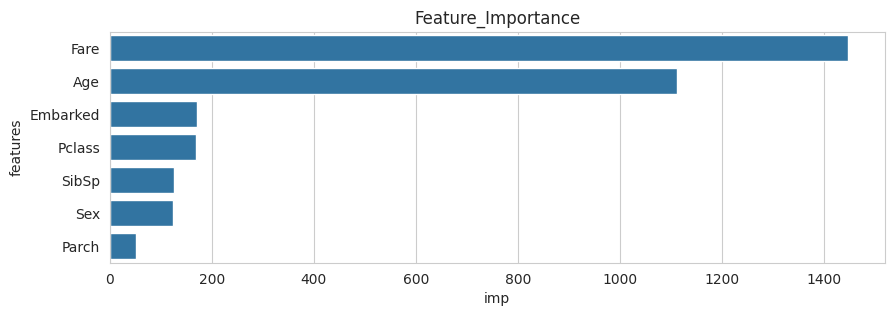

In [21]:
# 重要度の可視化
plt.figure(figsize=(10, 3))
sns.set_style("whitegrid")

sns.barplot(x="imp", y="features", data=imp_df)
plt.title("Feature_Importance")
plt.show()

## 提出ファイルの作成

In [22]:
# 単一モデルによるアンサンブル予測の定義
def models_predict_proba(X, models):
    print(f"n_models: {len(models)}")
    preds = []

    for model in models:
        pred = model.predict_proba(X)[:, 1]
        preds.append(pred)

    preds = np.array(preds)
    preds = np.mean(preds, axis=0)

    return preds

In [23]:
# 説明変数から目的変数の単一アンサンブル予測
y_pred = models_predict_proba(test[FEATURES], models)
# 予測を1か0に変換
y_pred = np.where(y_pred > 0.5, 1, 0)

# 提出ファイルのデータ作成
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": y_pred
})

n_models: 5


In [24]:
# 提出ファイルの作成
submission.to_csv(output_path / "submission_baseline.csv", index=False)

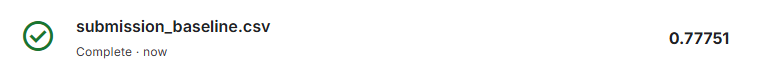

## まとめ

本ノートブックでは、シンプルなLightGBMを用いたベースラインの構築を行いました。  
このスコアを出発点として、今後のEDAおよび特徴量エンジニアリング、  
モデルの選定などを通じて、さらなる改善へとつなげていきます。  
より高い予測精度を目指し、本番ノートブックにて詳細な検討を進めてまいります。  


## 結果と今後の展望

- LightGBMを用いたベースライン構築が完了
- 提出スコア: **0.77751**
- 本番ノートブックにて、EDA・特徴量エンジニアリング・モデルの選定などを実施予定
